<a href="https://colab.research.google.com/github/Hotchapu13/Micro-Gas-Turbine-electrical-energy-Prediction/blob/bryant_branch1/Model_Implementation_III.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Loading the datasets

In [7]:
import pandas as pd

# Loading training and test datasets
train_df = pd.read_csv("/content/final_merged_file.csv")
test_df = pd.read_csv("/content/final_merged_file.csv")

#separating features
Taking the target variable as input_voltage

In [8]:
x_train = train_df.drop(columns=['input_voltage'])
y_train = train_df['input_voltage']

x_test = test_df.drop(columns=['input_voltage'])
y_test = test_df['input_voltage']

#Setting up K-Fold Cross Validation

In [11]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Initializing KFold wiht the number of splits
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_scores =[]
r2_scores = []

#Iterating over each fold
Trainign the model for each split and training the model on the training portion and validating it on the validation portion.

RMSE and R2 are recorded for each fold to evaueate model performance across folds


In [14]:
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Initializing KFold wiht the number of splits
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_scores =[]
r2_scores = []

for train_index, val_index in kfold.split(x_train):
    # Split data into current fold’s training and validation sets
    X_train_fold, X_val_fold = x_train.iloc[train_index], x_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Initialize XGBoost model
    model = xgb.XGBRegressor(learning_rate=0.1, n_estimators=1000, max_depth=6, random_state=42)

    # Create DMatrix for training and validation data
    dtrain = xgb.DMatrix(X_train_fold, label=y_train_fold)
    dval = xgb.DMatrix(X_val_fold, label=y_val_fold)

    # Train the model using xgb.train with early stopping
    # 'evals' parameter is used to specify the validation data for early stopping
    # 'early_stopping_rounds' parameter defines the number of rounds to wait for improvement before stopping
    model = xgb.train(
        model.get_xgb_params(),  # Get model parameters
        dtrain,
        num_boost_round=model.get_params()['n_estimators'],  # Get number of estimators
        evals=[(dval, 'eval')],  # Specify validation data for early stopping
        early_stopping_rounds=50,  # Set early stopping rounds
        verbose_eval=False  # Suppress verbose output
    )

    # Predict on validation fold
    y_val_pred = model.predict(dval)  # Use DMatrix for prediction

    # Calculate metrics for the validation fold
    rmse = np.sqrt(mean_squared_error(y_val_fold, y_val_pred))
    r2 = r2_score(y_val_fold, y_val_pred)

    # Store metrics for each fold
    rmse_scores.append(rmse)
    r2_scores.append(r2)

In [16]:
print("Average RMSE across folds: " + str(np.mean(rmse_scores)))
print("Average R2 across folds: " + str(np.mean(r2_scores)))

Average RMSE across folds: 0.4748986863015684
Average R2 across folds: 0.9700878954999188


# Prediction on the test set
Using the full training data to train the final model.
Finally predict on the test set

In [17]:
# Train the final model on all training data
final_model = xgb.XGBRegressor(learning_rate=0.1, n_estimators=1000, max_depth=6, random_state=42)
final_model.fit(x_train, y_train)

# Predict on the test set
test_df['Voltage_predicted'] = final_model.predict(x_test)


#Generating predicted values on the test dataset

In [19]:
y_test_pred = model.predict(xgb.DMatrix(x_test))

# Predicted vs Actual Value line plot
The actual and predicted values are plotted side to side for a sample of test data points


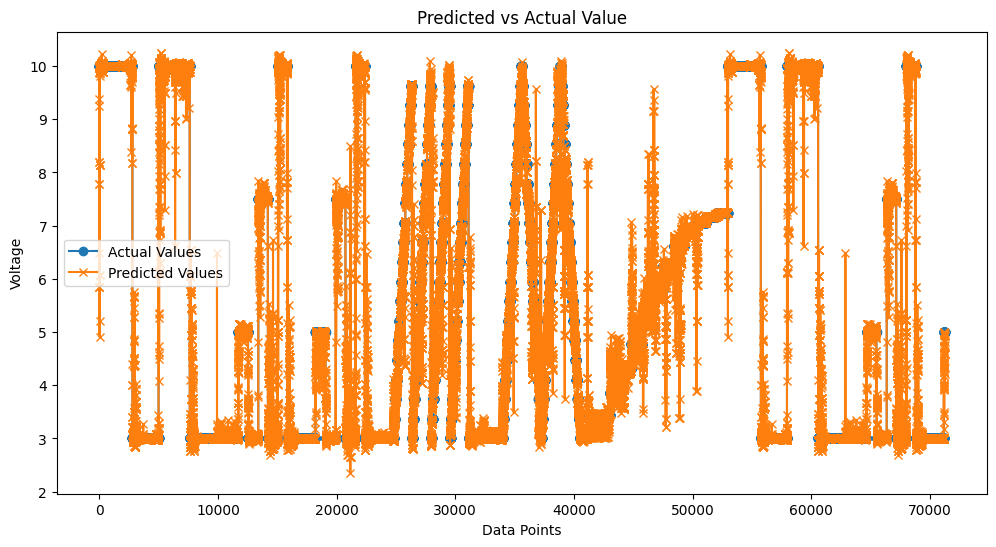

In [20]:
import matplotlib.pyplot as plt

# Plot actual and predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual Values', marker='o')
plt.plot(y_test_pred, label='Predicted Values', marker='x')
plt.title("Predicted vs Actual Value")
plt.xlabel("Data Points")
plt.ylabel("Voltage")
plt.legend()
plt.show()

# Scatter plot for Predicted vs Actual value

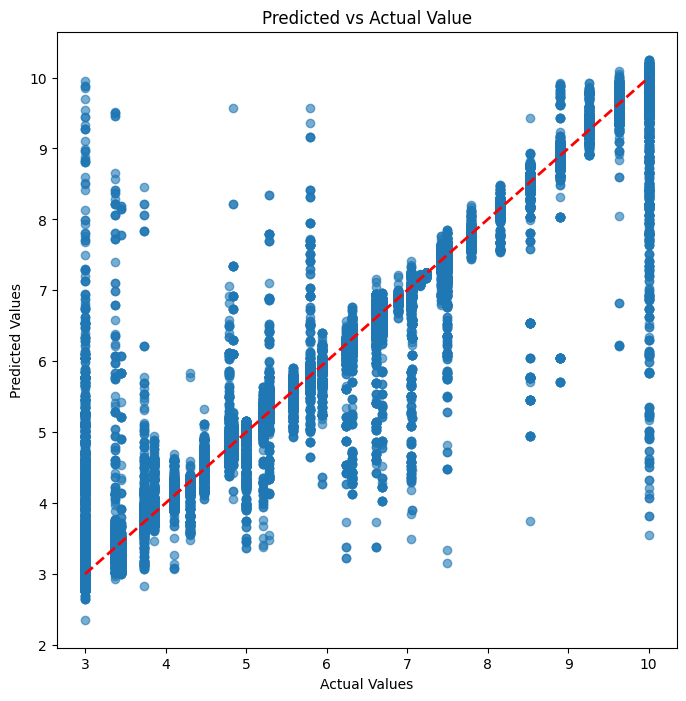

In [21]:
# Scatter plot of actual vs. predicted values
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_test_pred, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', lw=2)  # y = x line
plt.title("Predicted vs Actual Value")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()